In [1]:
import warnings

import numpy as np
import pandas as pd

pd.options.display.max_rows=500
pd.options.display.max_colwidth=2000


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from keras.models import Model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate
from keras.layers import CuDNNGRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')
np.random.seed(42)
EMBEDDING_FILE = '/media/stas/fastdata/data/cc.ru.300.vec'  # путь к рускому fasttext-у

df = pd.read_csv('./data/New_Data_Frame.csv')
df.drop_duplicates(inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["is_gogol"], stratify = df["is_gogol"], test_size=0.33, random_state=42)

/media/stas/fastdata/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
max_features = 30000
maxlen = 100
embed_size = 300
# Делаем токенизацию по словам и паддинг
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train) + list(X_test))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
x_train = sequence.pad_sequences(X_train, maxlen=maxlen)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen)

In [3]:
def get_coefs(word, *arr): return word, np.asarray(arr, dtype='float32')


# Делаем поготовку для embedding слоя
embeddings_index_crawl = dict(get_coefs(*o.rstrip().rsplit(' ')) for o in open(EMBEDDING_FILE))
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index_crawl.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [4]:
def get_model():
    sequence_input = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix], trainable = False)(sequence_input)
    x = SpatialDropout1D(0.2)(x)
    
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)
    x = Bidirectional(CuDNNGRU(128, return_sequences=True))(x)

    x1 = Conv1D(128, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    x1 = Conv1D(128, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x1)
    
    avg_pool_gru  = GlobalAveragePooling1D()(x)
    max_pool_gru  = GlobalMaxPooling1D()(x)
    avg_pool_conv = GlobalAveragePooling1D()(x1)
    max_pool_conv = GlobalMaxPooling1D()(x1)
    
    x = concatenate([avg_pool_gru, max_pool_gru, avg_pool_conv, max_pool_conv]) 
    x = Dense(256, activation="relu", kernel_initializer = "glorot_uniform")(x)
    x = Dense(256, activation="relu", kernel_initializer = "glorot_uniform")(x)
    
    preds = Dense(1, activation="sigmoid")(x)
    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=5e-4), metrics=['accuracy'])
    return model

model = get_model()

In [5]:
file_path  = "./models/weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

early = EarlyStopping(monitor="val_acc", mode="max", patience=3)


callbacks_list = [checkpoint, early]

hist = model.fit(x_train, y_train, batch_size=256, epochs=30, validation_split=0.2, callbacks=callbacks_list)

Train on 174308 samples, validate on 43578 samples
Epoch 1/30
174308/174308 [==============================] - 47s 271us/step - loss: 0.2060 - acc: 0.9139 - val_loss: 0.1439 - val_acc: 0.9424

Epoch 00001: val_acc improved from -inf to 0.94238, saving model to ./models/weights_base.best.hdf5
Epoch 2/30
174308/174308 [==============================] - 46s 264us/step - loss: 0.1451 - acc: 0.9413 - val_loss: 0.1280 - val_acc: 0.9478

Epoch 00002: val_acc improved from 0.94238 to 0.94784, saving model to ./models/weights_base.best.hdf5
Epoch 3/30
174308/174308 [==============================] - 46s 265us/step - loss: 0.1250 - acc: 0.9499 - val_loss: 0.1102 - val_acc: 0.9571

Epoch 00003: val_acc improved from 0.94784 to 0.95713, saving model to ./models/weights_base.best.hdf5
Epoch 4/30
174308/174308 [==============================] - 46s 266us/step - loss: 0.1146 - acc: 0.9541 - val_loss: 0.1083 - val_acc: 0.9573

Epoch 00004: val_acc improved from 0.95713 to 0.95729, saving model to ./mo

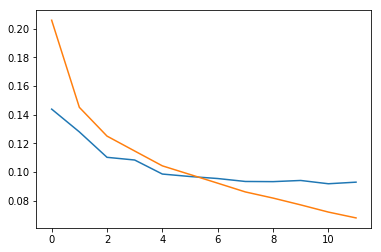

In [6]:
plt.plot(hist.history["val_loss"])
plt.plot(hist.history["loss"])

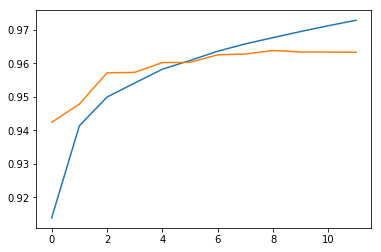

In [7]:
plt.plot(hist.history["acc"])
plt.plot(hist.history["val_acc"])

In [6]:
file_path  = "./models/weights_base.best.hdf5"
model.load_weights(file_path)
pred = model.predict(x_test, batch_size=1028)

pred_for_score = pred.copy().squeeze()
pred_for_score[pred_for_score >  0.5] = 1
pred_for_score[pred_for_score <= 0.5] = 0

print(accuracy_score(y_test,pred_for_score))

0.9621308832710568


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["is_gogol"], stratify = df["is_gogol"], test_size=0.33, random_state=42)
pred = model.predict(x_test,batch_size=1028)
pred -= 0.5
pred = np.abs(pred)

exporation_df = pd.DataFrame()
exporation_df["text"]= X_test
exporation_df["pred"]= pred
exporation_df.sort_values("pred", inplace=True)
exporation_df.head(25)

,text,pred
339141,"* И тогда она начинает длинно рассказывать, как погибли ее отец и семь братьев, убитые Ахиллом, и о пленении, выкупе и смерти матери.",0.000010
171067,"Гов орили с ним о Малорос сийской Истории, и проч.",0.000054
71698,Не позабывай по ней панихид.,0.000064
185192,"""...сидит на колу у турецкого султана, а Кузубия гуляет с рыбами на дне Сиваша"" -- упоминание о сражении под Перекопом в 1620 г., во время войны с турками.",0.000149
206031,"Пророки вообще много говорят об обширной торговле в Вавилоне, но они же рисуют ужасающую картину господствовавшей там безнравственности.",0.000169
140799,"Филонов был одно время совершенный атеист, libre penseur.",0.000292
256133,которого мы теперь не касаемся.,0.000318
311157,На эту сторону дела впервые указал именно Гегель.,0.000318
99283,А доказательство в наше время.,0.000366
254787,Примечание 4 Непостижимость начала .,0.000405
